In [1]:
import pandas as pd
import numpy as np
import keras.layers
import matplotlib.pyplot as plt
import pandas
import math
import seaborn as sns
from keras import Sequential
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import statsmodels.formula.api as smf

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [8]:
#IMPORT DATA
data = pd.read_csv('US_UNEM_QT.csv',index_col = 'date')

#SET DATA TIMEFRAME
begin = '1979-12-31'


#end = '2016-12-31'
end = '2020-08-01'

data = data[begin:end]
datamin = data['UNRATE'].min()
datamax = data['UNRATE'].max()


In [10]:
#Process and Format the Data

def process_data(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    #input sequence for (t-n,.... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i) ) for j in range(n_vars)]
       
    #forecast sequence for (t, t+1, .... t+n)
    for i in range (0, n_out):
        cols.append(df.shift(-i))
        if i == 0: 
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names +=[('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

scaler = MinMaxScaler(feature_range=(0, 1))
data[data.columns] = scaler.fit_transform(data[data.columns])
values = data.values


#scaled = scaler.fit_transform(values)
reframed = process_data(values,2,3)


C:\Users\wilgr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [43]:

#finalise the formatting
values = reframed.values
n_train = int(len(values) * 0.9)
train= values[:n_train,:]
test = values[n_train:,:]
train_x, train_y = train[:, 1:], train[:, 0]
test_x, test_y = test[:, 1:], test[:, 0]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1])



In [44]:
#Create LSTM model

#options here for the Keras framework - adagrad and adamax work best  -  feel free to swap in the optimizer slot below
rms = keras.optimizers.rmsprop(lr = 0.005, decay = .00001)
adagrad = keras.optimizers.adagrad(lr= 0.0075)
Nadam = keras.optimizers.Nadam(lr = 0.001)
adamax = keras.optimizers.adamax(lr = .005, decay = .001)
sgd = keras.optimizers.sgd(lr=0.1, decay =0.001)
drop = 0.01
model = Sequential()
model.add(LSTM(200, activation = 'relu', recurrent_dropout = drop,  input_shape= (train_x.shape[1], train_x.shape[2])))
#model.add(LSTM(50, activation = 'relu',  input_shape= (train_x.shape[1], train_x.shape[2])))
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(drop))
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(drop))
model.add(Dense(200, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = adamax ,loss = 'mean_squared_error')
hist = model.fit(train_x, train_y, epochs = 300, shuffle = False, validation_data=(test_x, test_y))#callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto')])

Train on 116 samples, validate on 13 samples
Epoch 1/300
116/116 [==============================] - 3s 27ms/step - loss: 0.1774 - val_loss: 0.2437
Epoch 2/300
116/116 [==============================] - 0s 421us/step - loss: 0.0629 - val_loss: 0.3581
Epoch 3/300
116/116 [==============================] - 0s 507us/step - loss: 0.0632 - val_loss: 0.2273
Epoch 4/300
116/116 [==============================] - 0s 447us/step - loss: 0.0442 - val_loss: 0.1326
Epoch 5/300
116/116 [==============================] - 0s 458us/step - loss: 0.0251 - val_loss: 0.1724
Epoch 6/300
116/116 [==============================] - 0s 456us/step - loss: 0.0154 - val_loss: 0.2297
Epoch 7/300
116/116 [==============================] - ETA: 0s - loss: 0.014 - 0s 507us/step - loss: 0.0134 - val_loss: 0.2106
Epoch 8/300
116/116 [==============================] - 0s 456us/step - loss: 0.0111 - val_loss: 0.1503
Epoch 9/300
116/116 [==============================] - 0s 533us/step - loss: 0.0098 - val_loss: 0.1004
Epoch

116/116 [==============================] - 0s 585us/step - loss: 6.8759e-04 - val_loss: 0.0059
Epoch 78/300
116/116 [==============================] - 0s 507us/step - loss: 5.7854e-04 - val_loss: 0.0039
Epoch 79/300
116/116 [==============================] - 0s 542us/step - loss: 5.1789e-04 - val_loss: 0.0056
Epoch 80/300
116/116 [==============================] - 0s 499us/step - loss: 4.2389e-04 - val_loss: 0.0042
Epoch 81/300
116/116 [==============================] - 0s 511us/step - loss: 3.9198e-04 - val_loss: 0.0041
Epoch 82/300
116/116 [==============================] - 0s 560us/step - loss: 4.1945e-04 - val_loss: 0.0033
Epoch 83/300
116/116 [==============================] - 0s 731us/step - loss: 4.1336e-04 - val_loss: 0.0033
Epoch 84/300
116/116 [==============================] - 0s 464us/step - loss: 3.9660e-04 - val_loss: 0.0022
Epoch 85/300
116/116 [==============================] - 0s 490us/step - loss: 5.2118e-04 - val_loss: 0.0035
Epoch 86/300
116/116 [===================

116/116 [==============================] - 0s 602us/step - loss: 3.5564e-04 - val_loss: 0.0016
Epoch 153/300
116/116 [==============================] - 0s 867us/step - loss: 3.4690e-04 - val_loss: 0.0061
Epoch 154/300
116/116 [==============================] - 0s 645us/step - loss: 3.8797e-04 - val_loss: 0.0027
Epoch 155/300
116/116 [==============================] - 0s 576us/step - loss: 3.6434e-04 - val_loss: 0.0058
Epoch 156/300
116/116 [==============================] - 0s 481us/step - loss: 3.0075e-04 - val_loss: 0.0029
Epoch 157/300
116/116 [==============================] - 0s 499us/step - loss: 3.0001e-04 - val_loss: 0.0038
Epoch 158/300
116/116 [==============================] - 0s 479us/step - loss: 3.3037e-04 - val_loss: 0.0026
Epoch 159/300
116/116 [==============================] - 0s 542us/step - loss: 3.2282e-04 - val_loss: 0.0023
Epoch 160/300
116/116 [==============================] - 0s 576us/step - loss: 2.8008e-04 - val_loss: 0.0027
Epoch 161/300
116/116 [==========

KeyboardInterrupt: 

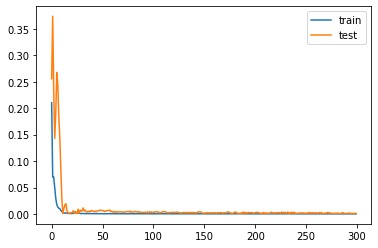

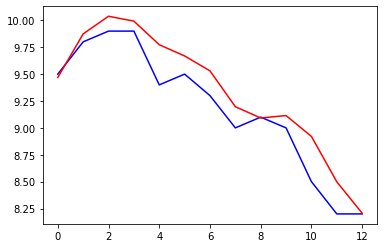

In [31]:
#Plot train against test loss
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

#convert the data back to the original values
chat = model.predict(train_x)
yhat = model.predict(test_x)
corrected = test_y*(datamax-datamin)+datamin
correctedpred = yhat*(datamax-datamin)+datamin
correctedpred = correctedpred.ravel()

#Plot the actual test values against the training values
plt.plot(corrected, color = 'b')
plt.plot(correctedpred, color='R')
#phot output if needed 
plt.savefig('tLSTM.png')
plt.show()

mse_nominal: 0.047769362428452616
rmse_nominal: 0.21856203336456362
mse_scaled: 8.402653e-07
rmse_nominal: 0.0009166598455657403


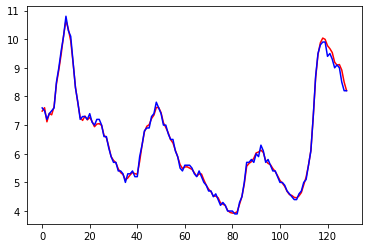

In [34]:
#mean squared errore with nominal values
mse_nominal = ((corrected[:-1]-correctedpred[:-1])**2).mean()
#root mean squared error with nominal values
rmse_nominal = mse_nominal **(1/2)
#mean squared error scaled
mse_scaled = ((test_y[-1]-yhat[-1].ravel()) **2).mean()
#root mean squared error scaled
rmse_scaled = mse_scaled **(1/2)

print('mse_nominal:', mse_nominal)
print('rmse_nominal:', rmse_nominal)
print('mse_scaled:', mse_scaled)
print('rmse_nominal:', rmse_scaled)

#full data set for plotting
that = np.append(chat,yhat)
cthat = that*(datamax-datamin)+datamin
ythat = np.append(train_y,test_y)
cythat = ythat*(datamax-datamin)+datamin

plt.plot(cthat, color = 'red')
plt.plot(cythat, color = 'b')
plt.show()




In [25]:
#lstmpred = pd.DataFrame(correctedpred)
#lstmpred.to_csv('lstmpred.csv')

Convert RMSE from Rohit's fnn

In [39]:
rmselgfnnminimized = 0.04766    #easiest to just input the value here but feel free to build an import function if you like
rmselgfnn = rmselgfnnminimized*(datamax-datamin)
print(rmselgfnn)
rmsefnnmin = 0.05128 
rmsefnn = rmsefnnmin* (datamax-datamin)
print(rmsefnn)

0.32885400000000004
0.35383200000000004
